# STDP

The purpose of this notebook is to investigate the default dynamics of STDP-type rules, in feedforward and recurrent networks, with Poisson and simple behaviour.

In [6]:
import brian2 as b2
from brian2 import numpy as np
from tqdm import tqdm

## STDP on Poisson Neurons

In [43]:
USE_TRIPLET = False
USE_WEIGHT_DEPENDENCE = True
USE_RESPONSIVE_NEURONS = False
USE_RECURRENCE = False
N_RUNS = 50

In [ ]:
b2.start_scope()

N_input = 1000
N_output = 100
recurrent = False
input_rate = 25 * b2.Hz  # should be compared with STDP kernel width
output_rate = 15 * b2.Hz

taum = 10*b2.ms
taupre = 20*b2.ms
taupost = taupre
taupost_slow = 100*b2.ms
# mu = 0.05
mu_vals = np.linspace(0, 1, N_RUNS)

gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost
if not (USE_TRIPLET or USE_WEIGHT_DEPENDENCE):
    dApost *= 1.05
dApost *= gmax
dApre *= gmax

Ee = 0*b2.mV
vt = -54*b2.mV
vr = -60*b2.mV
El = -74*b2.mV
taue = 5*b2.ms

neuron_model = '''
dv/dt = (ge * (Ee-vr) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

synapse_model = '''
    w : 1
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)
    mu : 1
    '''
if USE_TRIPLET:
    synapse_model += '''
        dApost_slow/dt = -Apost_slow / taupost_slow : 1 (event-driven)
        '''
if USE_WEIGHT_DEPENDENCE:
    on_pre = '''
        Apre += dApre
        w = clip(w + Apost*w**mu, 0, gmax)
        '''
else:
    on_pre = '''
        Apre += dApre
        w = clip(w + Apost, 0, gmax)
        '''
if USE_RESPONSIVE_NEURONS:
    on_pre += '''
        ge += w
        '''
if USE_TRIPLET:
    if USE_WEIGHT_DEPENDENCE:
        on_post = '''
            Apost += dApost
            w = clip(w + Apre*Apost_slow*(gmax-w)**mu, 0, gmax)
            Apost_slow += dApost
            '''
    else:
        on_post = '''
            Apost += dApost
            w = clip(w + Apre*Apost_slow, 0, gmax)
            Apost_slow += dApost
            '''
else:
    if USE_WEIGHT_DEPENDENCE:
        on_post = '''
            Apost += dApost
            w = clip(w + Apre*(gmax-w)**mu, 0, gmax)
            '''
    else:
        on_post = '''
            Apost += dApost
            w = clip(w + Apre, 0, gmax)
            '''

input_group = b2.PoissonGroup(
    N=N_input,
    rates=input_rate
)
if USE_RESPONSIVE_NEURONS:
    output_group = b2.NeuronGroup(
        N=N_output,
        model=neuron_model,
        threshold='v>vt',
        reset='v = vr',
        method='linear'
    )
    ratemon = b2.PopulationRateMonitor(
        output_group
    )
else:
    output_group = b2.PoissonGroup(
        N=N_output,
        rates=output_rate
    )

synapse_input = b2.Synapses(
    source=input_group,
    target=output_group,
    model=synapse_model,
    on_pre=on_pre,
    on_post=on_post,
     )
synapse_input.connect()
synapse_input.w = 'rand() * gmax'
statemon_input = b2.StateMonitor(synapse_input, 'w', record=[0, 1])

if USE_RECURRENCE:
    synapse_recurrent = b2.Synapses(
        source=output_group,
        target=output_group,
        model=synapse_model,
        on_pre=on_pre,
        on_post=on_post,
         )
    synapse_recurrent.connect()
    synapse_recurrent.w = 'rand() * gmax'
    statemon_recurrent = b2.StateMonitor(synapse_recurrent, 'w', record=[0, 1])

    weights_before = np.zeros((N_output,N_output))
    weights_before[synapse_recurrent.i[:], synapse_recurrent.j[:]] = synapse_recurrent.w[:]

bins = 50
weights_array = np.zeros((bins, N_RUNS))

# net = b2.Network(b2.collect())

b2.store('initialized')
for run_idx in tqdm(range(N_RUNS)):
    b2.restore('initialized')
    synapse_input.mu = mu_vals[run_idx]
    b2.run(100*b2.second)  #, report='text')
    w_hist, _, _ = b2.hist(synapse_input.w, range=(0,gmax), bins=bins, density=True)
    weights_array[:, run_idx] = w_hist

  8%|▊         | 4/50 [04:47<53:58, 70.40s/it]

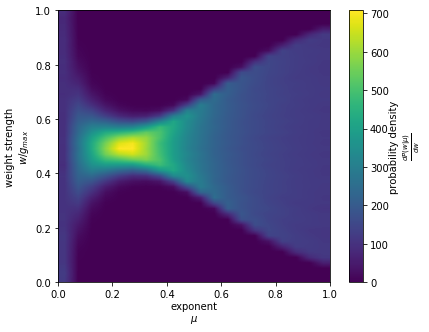

In [42]:
# b2.figure(figsize=(7,5))
extent = [0, 1, 0, 1]
b2.imshow(weights_array, interpolation='bilinear', extent=extent)
b2.xlabel('exponent\n$\mu$')
b2.ylabel('weight strength\n'+r'$w/g_{max}$')
b2.colorbar(label='probability density\n'+r'$\frac{dP(w|\mu)}{dw}$')

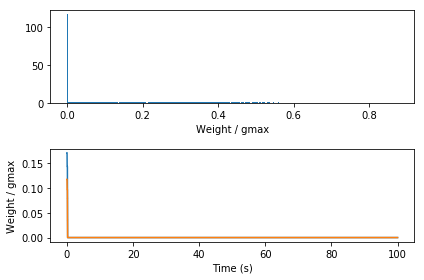

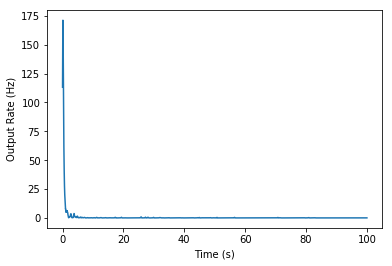

In [97]:
# b2.subplot(311)
# b2.plot(synapse_input.w / gmax, '.k')
# b2.ylabel('Weight / gmax')
# b2.xlabel('Synapse index')
b2.figure()
b2.subplot(211)
b2.hist(synapse_input.w / gmax, int(np.sqrt(synapse_input.w.shape)), density=True)
b2.xlabel('Weight / gmax')
b2.subplot(212)
b2.plot(statemon_input.t/b2.second, statemon_input.w.T/gmax)
b2.xlabel('Time (s)')
b2.ylabel('Weight / gmax')
b2.tight_layout()

if USE_RECURRENCE:
    b2.figure()
    b2.subplot(211)
    b2.hist(synapse_recurrent.w / gmax, int(np.sqrt(synapse_recurrent.w.shape)), density=True)
    b2.xlabel('Weight / gmax')
    b2.subplot(212)
    b2.plot(statemon_recurrent.t/b2.second, statemon_recurrent.w.T/gmax)
    b2.xlabel('Time (s)')
    b2.ylabel('Weight / gmax')
    b2.tight_layout()

    b2.figure()
    weights_after = np.zeros((N_output,N_output))
    weights_after[synapse_recurrent.i[:], synapse_recurrent.j[:]] = synapse_recurrent.w[:]
    b2.subplot(121)
    b2.imshow(weights_before)
    b2.subplot(122)
    b2.imshow(weights_after)

if USE_RESPONSIVE_NEURONS:
    b2.figure()
    b2.plot(ratemon.t / b2.second, ratemon.smooth_rate(window='gaussian', width=100*b2.ms)/b2.Hz)
    b2.xlabel('Time (s)')
    b2.ylabel('Output Rate (Hz)')
b2.show()

## STDP on Responsive Output Neurons

Starting simulation at t=0. s for a duration of 100. s
14.629800000000001 (14%) simulated in 10s, estimated 58s remaining.
29.3186 (29%) simulated in 20s, estimated 48s remaining.
44.0277 (44%) simulated in 30s, estimated 38s remaining.
58.7068 (58%) simulated in 40s, estimated 28s remaining.
73.4423 (73%) simulated in 50s, estimated 18s remaining.
88.14240000000001 (88%) simulated in 1m 0s, estimated 8s remaining.
100.0 (100%) simulated in 1m 8s


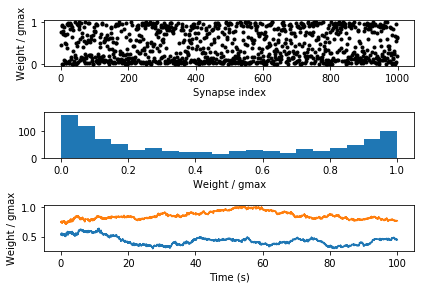

In [9]:
b2.start_scope()

N = 1000
taum = 10*b2.ms
taupre = 20*b2.ms
taupost = taupre
Ee = 0*b2.mV
vt = -54*b2.mV
vr = -60*b2.mV
El = -74*b2.mV
taue = 5*b2.ms

eqs_neurons = '''
dv/dt = (ge * (Ee-vr) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

F = 15*b2.Hz
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

eqs_neurons = '''
dv/dt = (ge * (Ee-vr) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

input = b2.PoissonGroup(N, rates=F)
neurons = b2.NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                      method='linear')
S = b2.Synapses(input, neurons,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )
S.connect()
S.w = 'rand() * gmax'
state_mon = b2.StateMonitor(S, 'w', record=[0, 1])
spike_mon = b2.SpikeMonitor(input)
rate_mon = b2.PopulationRateMonitor(neurons)

b2.run(100*b2.second, report='text')

b2.subplot(311)
b2.plot(S.w / gmax, '.k')
b2.ylabel('Weight / gmax')
b2.xlabel('Synapse index')
b2.subplot(312)
b2.hist(S.w / gmax, 20)
b2.xlabel('Weight / gmax')
b2.subplot(313)
b2.plot(state_mon.t/b2.second, state_mon.w.T/gmax)
b2.xlabel('Time (s)')
b2.ylabel('Weight / gmax')
b2.tight_layout()
b2.show()

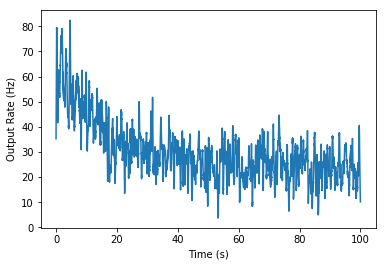

In [21]:
b2.plot(rate_mon.t/b2.second, rate_mon.smooth_rate(window='gaussian', width=100*b2.ms)/b2.Hz)
b2.xlabel('Time (s)')
b2.ylabel('Output Rate (Hz)')
b2.show()